# Registration

Correct for rigid/non-rigid movement

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

In [1]:
# Imports

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd

import mesmerize_core as mc
import numpy as np
import tifffile
from matplotlib import pyplot as plt

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import lbm_caiman_python as lcp

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

WGPU: enumerate_adapters() is deprecated, use enumerate_adapters_sync() instead.
WGPU: request_adapter() is deprecated, use request_adapter_sync() instead.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.


### (optional): View hardware information

In [236]:
!pip install cloudmesh-cmd5
!cms help # dont forget to call it after the install as it sets some defaults
!cms sysinfo

*** No help on # dont forget to call it after the install as it sets some defaults
+------------------+----------------------------------------------------------------------------------------------+
| Attribute        | Value                                                                                        |
+------------------+----------------------------------------------------------------------------------------------+
| cpu              |                                                                                              |
| cpu_cores        | 24                                                                                           |
| cpu_count        | 32                                                                                           |
| cpu_threads      | 32                                                                                           |
| date             | 2024-12-09 17:10:54.386633                                                          

### Data path setup

We set 2 path variables:

1. `data_path` : input, path where you saved the output from the assembly step
2. `batch_path` : results, can be anywhere you please, must end in .pickle

```{note}
This notebook assumes you saved scans as TIFF with `join_contiguous=True` so filenames are `plane_N.tiff`
The process for `join_contiguous=False` is the same, but with the roi attached to the filename `plane_N_roi_M`.
```
To simplify data management, we put our batch_path (which stores results) in the same directory as our raw data.

In [2]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out'  # where the output files from the assembly step are located
batch_path = data_path / 'batch_v2.pickle'

In [3]:
tiff_files = [x for x in Path(data_path).glob('*.tif*')]
tiff_files

[WindowsPath('C:/Users/RBO/caiman_data/out/plane_1.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_10.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_11.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_12.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_13.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_14.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_15.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_16.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_17.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_18.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_19.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_2.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_20.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_21.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_22.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_23.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out

### Load a data file to examine

In [4]:
file = tiff_files[1]
data = tifffile.imread(file)
data.shape

(1730, 600, 576)

## View metadata

`lcp.get_metadata(filepath)` works on raw scanimage files and files processed through `lcp.save_as()`

In [5]:
metadata = lcp.get_metadata(file)
metadata

{'image_height': 2478,
 'image_width': 145,
 'num_pages': 51900,
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'shape': [51900, 2478, 145],
 'num_planes': 30,
 'num_rois': 4,
 'num_frames': 1730.0,
 'frame_rate': 9.60806,
 'fov': [150, 600],
 'pixel_resolution': [1.04, 1.0],
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'num_lines_between_scanfields': 24,
 'center_xy': [-1.428571429, 0],
 'line_period': 4.15652e-05,
 'size_xy': [0.9523809524, 3.80952381],
 'objective_resolution': 157.5}

In [6]:
dxy = metadata['pixel_resolution']
print(f"Pixel resolution: {dxy[0]} um/px, {dxy[1]} um/px")

Pixel resolution: 1.04 um/px, 1.0 um/px


In [7]:
# note this is only for a single ROI
fov = metadata['fov']
print(f"Field of View: {fov[0]}px, {fov[1]}px")

Field of View: 150px, 600px


In [8]:
fr = metadata['frame_rate']
print(f"Frame rate: {fr} Hz")

Frame rate: 9.60806 Hz


# Registration parameters

| Parameter               | Description                                                                                     | Value/Default                  |
|-------------------------|-------------------------------------------------------------------------------------------------|--------------------------------|
| `dxy`                  | Spatial resolution (pixel size in micrometers).                                                 | `dxy` (from metadata)           |
| `fr`                   | Frame rate of the video (frames per second).                                                    | `fr` (from metadata)            |
| `max_shifts`           | Maximum allowed rigid shift in pixels for motion correction.                                     | `(int(10/dxy), int(10/dxy))`   |
| `strides`              | Size of patches for motion correction.                                                          | `[48, 48]`                     |
| `overlaps`             | Overlap between patches for motion correction.                                                  | `[24, 24]`                     |
| `max_deviation_rigid`  | Maximum allowed deviation for patches relative to rigid shifts.                                  | `3`                            |
| `border_nan`           | How to handle border values during motion correction.                                            | `'copy'`                       |
| `pw_rigid`             | Flag indicating whether to perform piecewise rigid motion correction.                            | `False`                        |
| `gSig_filt`            | Size of the Gaussian filter for smoothing the motion correction process.                         | `(3, 3)`                       |
| `shifts_opencv`        | Flag to use bicubic interpolation for motion correction.                                         | `True`                         |

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

## Using metadata to assign parameter values

```{important}
The goal here is to get an approximate neuron size in microns.
This value is used as the basis of the `patch` and `max_shifts` parameters.
```

`plot_data_with_scalebars` will give you 3 images, at 5, 10 and 20 um.

You can use any summary images:

```python
# a single frame
plot_with_scalebars(data[0, :, :], np.mean(dxy))           

# mean projection image
plot_with_scalebars(np.mean(data, axis=0), np.mean(dxy))  

# maximum projection image
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))    
```

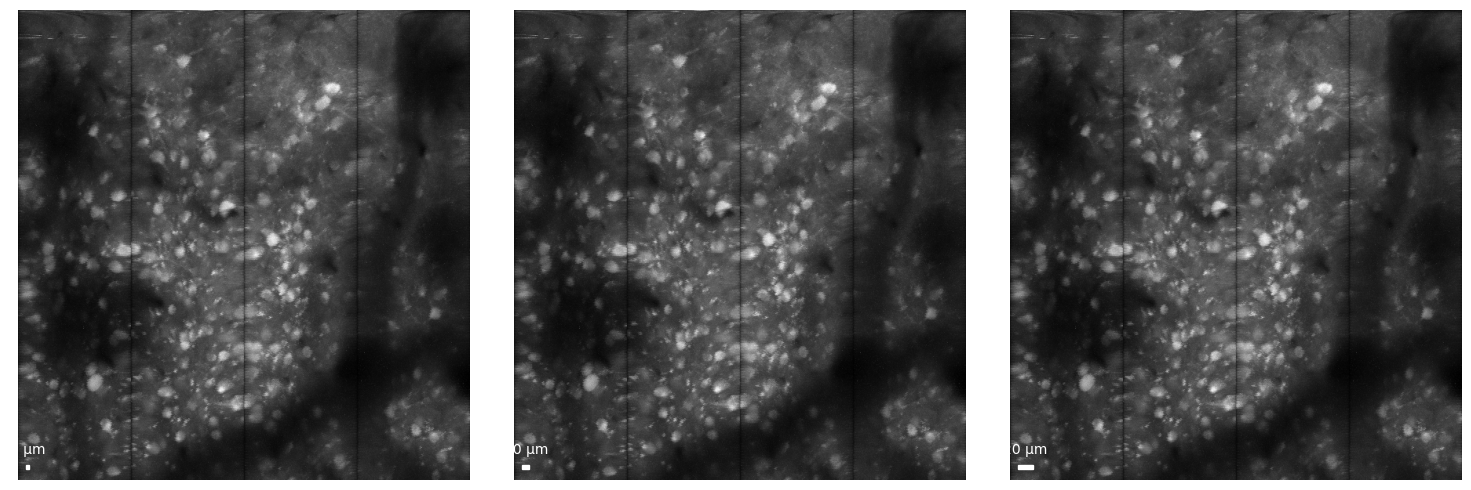

In [9]:
from lbm_caiman_python import plot_with_scalebars

# plot_with_scalebars(data[0, :, :], np.mean(dxy))
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))

## Scaling patches relative to neuron size

The `generate_patch_view` function divides the image into patches the same way CaImAn will do internally.

Increasing / decreasing the `target_patch_size` and `overlap_fraction` parameters to examine the effect of different stride/overlap values displayed in the title. 

```{tip}
We want each patch to have "landmarks" (neurons) to use for alignment, so we want at least a few full neurons for each patch.

For this reason, we use the `neuron_size` * `scale_factor` as our `target_patch_size`.

We want to **avoid** neurons occupying the inner regions of multiple neighboring patches.
```

In [10]:
neuron_size = 15    # in micron

# - value of 1 makes patches ~neuron sized
# - value of 2 makes patches ~2x neuron sized
# - the larger your neurons, the larger you want to make this number
scale_factor = 3 # must be > 0

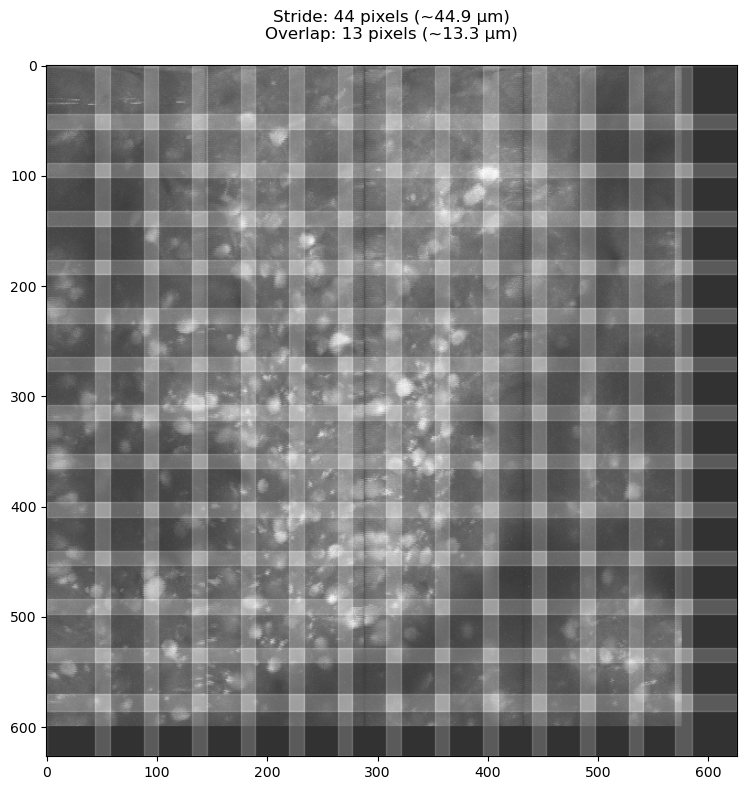

In [11]:
from lbm_caiman_python import generate_patch_view

target_patch_size=neuron_size*scale_factor    
overlap_fraction = scale_factor / 10           # 30% of our patch will be processed by neighboring patches as well 

# this function assumes a square pixel resolution, so take the mean
fig, ax, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
plt.show()

In [12]:
print(f'stride : {stride_px}px\noverlap: {overlap_px}px')

stride : 44px
overlap: 13px


In [13]:
# From the above image, we get our overlaps/strides parameters
# This is in *pixels*, not microns
strides = [stride_px, stride_px]
overlaps = [overlap_px, overlap_px]

## Create the parameters we pass to CaImAn

The above patch view looks good, so we use those values in our parameters dictionary.

You *can* also include segmentation parameters in this dictionary if you wish. This is *not recommmended* as several parameters share similar names yet perform different actions. i.e:
-  `stride` and `gSig_filt` parameters are for registration
-  `strides` for `gSig` are parameters for segmentation

```{note}
We want our parameters to physically make sense. 

`max_shifts` controls the maximum number of pixels that each individual patch can be shifted.

We don't want to shift any patches more than a full overlap which would introduce artifacts into neighboring patches.
```

In [14]:
max_shifts = (int(overlaps[0] / 2), int(overlaps[0] / 2))   # maximum allowed rigid shift in pixels 
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                       # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True                  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'dxy': dxy,
        'fr': fr,
        'max_shifts': max_shifts, # make sure its a tuple/list of integers
        'strides': strides,
        'overlaps': overlaps,
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': (3, 3),
    },
}

### Run registration with `mesmerize-core`

See the mesmerize-core [utility docs](https://mesmerize-core.readthedocs.io/en/latest/api/functions.html) for more information on batch creation.


### Create or load a batch set

```{warning}
In the below if-else clause, be careful if you expect a batch to exist, a typo can be deceiving!
```

In [16]:
# Create or load a batch results file
# To overwrite:
# df = mc.create_batch(batch_path, remove_existing=True)

if not batch_path.exists():
    print(f'creating batch: {batch_path}')
    df = mc.create_batch(batch_path)
else:
    df = mc.load_batch(batch_path)

# tell mesmerize where the raw data is
mc.set_parent_raw_data_path(data_path)
df

creating batch: C:\Users\RBO\caiman_data\out\batch_v2.pickle


,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid


### Add an item to the batch

A "batch item" consists of:
* algorithm to run, `algo` 
    - currently: mcorr, cnmf, cnmfe
* input movie to run the algorithm on, `input_movie_path`
    - can be string or dataframe row
* parameters for the specified algorithm, `params`
* a name for you to keep track of things `item_name`
    - can be anything

In [17]:
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=file,
    params=mcorr_params,
    item_name='mcorr',
)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",None,2024-12-09T17:18:15,None,None,None,790b1747-10dd-498f-a11b-dbc267b5c1fd


## First registration run

```{note}
On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.
For this reason, on windows you need to reload the dataframe:
```
```python
df=df.caiman.reload_from_disk()
df
```

If you ever get errors like 

```python
TypeError: NoneType is not subscriptable
```
**This likely means you need to reload the dataframe**.

```{warning}
On windows, `df.iloc[i].caiman.run()` will sometimes stall if you run additional cells before it completes.
```

In [18]:
df.iloc[0].caiman.run()

Running 790b1747-10dd-498f-a11b-dbc267b5c1fd with local backend
starting mc


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [19]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': 790b1747-10dd-498f-a11b-dbc267b5c1fd\790b1747-10dd-498f-a11b-dbc267b5c1fd_mean_projection.n...,2024-12-09T17:18:15,2024-12-09T17:19:47,79.33 sec,None,790b1747-10dd-498f-a11b-dbc267b5c1fd


### Check for errors in outputs

In the table header **outputs**, you should see 

```python
{'mean-projection-path': ...}
```
If you see instead:

```python
{'success': False, ...}
```

Run the below cell to evaluate the error message.

In [20]:
import pprint
pprint.pprint(df.iloc[0].outputs["traceback"])

None


## Evaluate motion correction outputs with `mesmerize-core` API 

mesmerize-core offers an easy [API](https://mesmerize-core.readthedocs.io/en/latest/api/mcorr.html) to retrieve results from the batch dataframe.

In [85]:
# get the motion corrected movie memmap
mcorr_movie = df.iloc[0].mcorr.get_output()
mcorr_shifts = df.iloc[0].mcorr.get_shifts()

# the input movie, note that we use `.caiman` here instead of `.mcorr`
input_movie = df.iloc[0].caiman.get_input_movie()

### Side-by-side with `fastplotlib`

Its helpful to zoom into specific locations of your images to see improvements.

RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='900px')
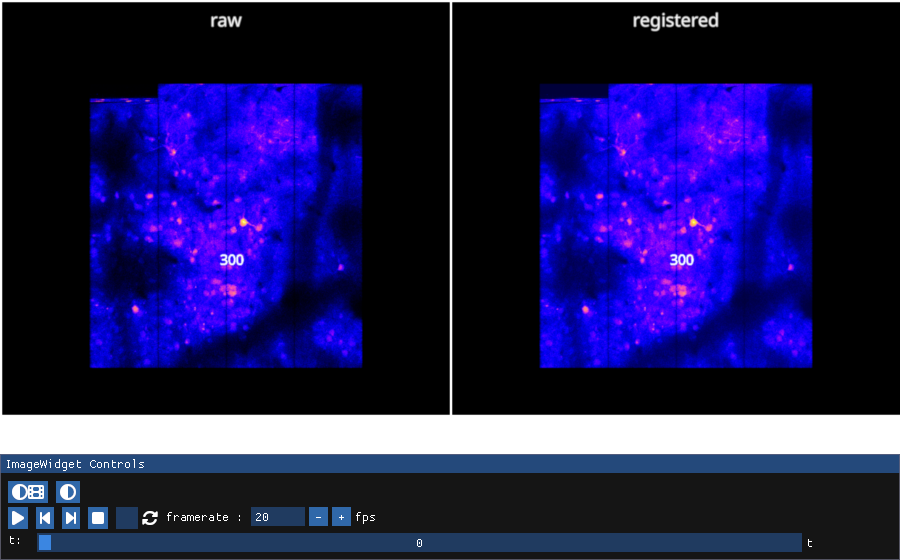

In [87]:
import fastplotlib as fpl

mcorr_iw = fpl.ImageWidget(
    data=[input_movie, mcorr_movie],
    names=['raw', 'registered'],
    cmap="gnuplot2",
    window_funcs={"t": (np.mean, 3)}, # window functions as a kwarg, this is what the slider was used for in the ready-made viz
    figure_kwargs={"size": (900, 560)},
    histogram_widget=False, # helps keep plots close together
)
mcorr_iw.show()

In [88]:
mcorr_iw.close()

# Define parameter varients

If you still see non-rigid motion in your movie, we can try increasing the scale_factor to increase our patch-size or decrease it. 

More than likely you will want to decrease the scale factor to process more patches.

The patched graphs displayed show you what patches each of your movie will use.

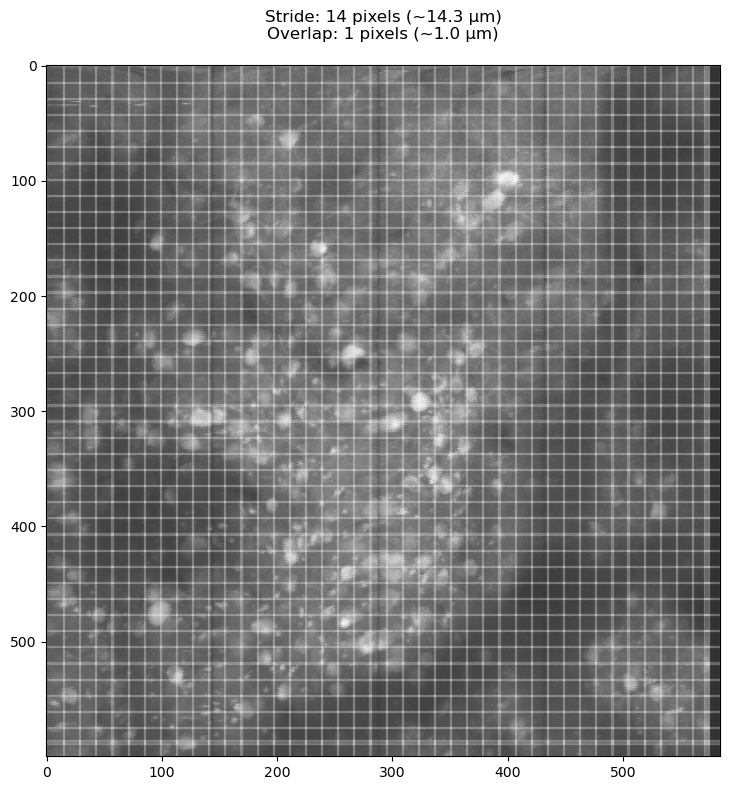

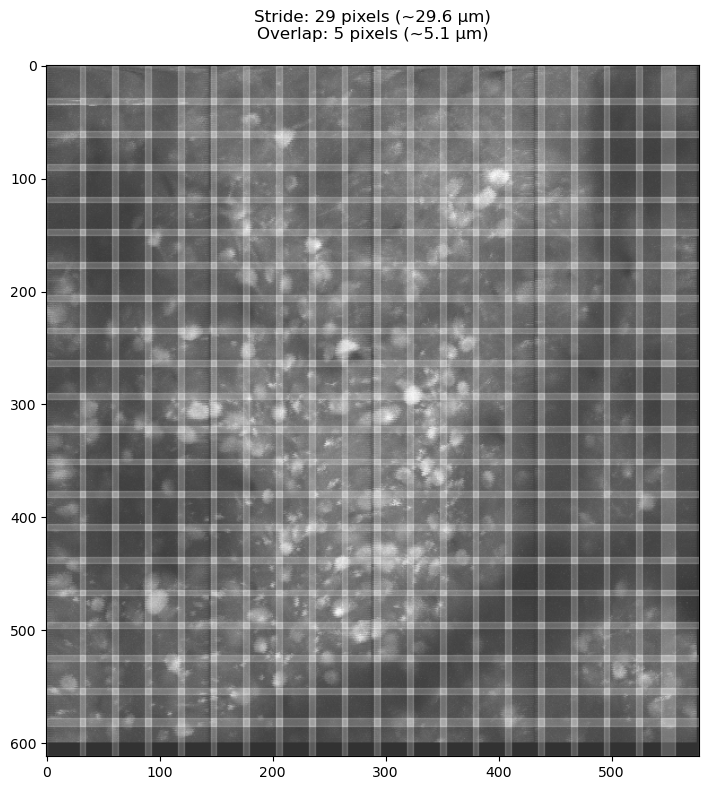

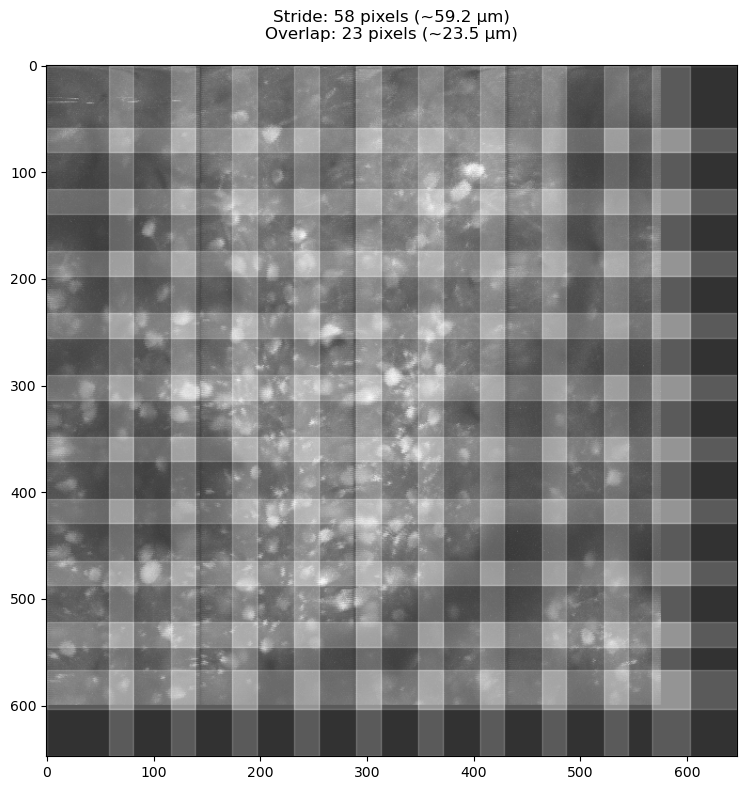

In [22]:
from copy import deepcopy

for scale in (scale_factor-2, scale_factor-1, scale_factor+1):
    target_patch_size=neuron_size*scale    
    overlap_fraction = scale / 10
    
    _, _, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
    
    # deep copy is the safest way to copy dicts
    new_params = deepcopy(mcorr_params)

    new_shift = int(np.ceil(overlap_px / 2))
    new_stride = int(np.ceil(stride_px))
    new_overlap = int(np.ceil(overlap_px))

    new_params["main"]["max_shifts"] = (new_shift, new_shift)
    new_params["main"]["strides"] = (new_stride, new_stride)
    new_params["main"]["overlaps"] = (new_overlap, new_overlap)

    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=file,
        params=new_params,
        item_name='mcorr',  # filename of the movie, but can be anything
    )

In [23]:
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': 790b1747-10dd-498f-a11b-dbc267b5c1fd\790b1747-10dd-498f-a11b-dbc267b5c1fd_mean_projection.n...,2024-12-09T17:18:15,2024-12-09T17:19:47,79.33 sec,None,790b1747-10dd-498f-a11b-dbc267b5c1fd
1,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (1, 1), 'strides': (14, 14), 'overlaps': (1, 1), 'max_dev...",None,2024-12-09T17:39:04,None,None,None,8c1d98d9-57a1-414f-a046-b678cc7a8410
2,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (3, 3), 'strides': (29, 29), 'overlaps': (5, 5), 'max_dev...",None,2024-12-09T17:39:04,None,None,None,5c844e2a-924b-469f-87b4-fd81db666020
3,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (12, 12), 'strides': (58, 58), 'overlaps': (23, 23), 'max...",None,2024-12-09T17:39:04,None,None,None,d7a55f83-6d9d-40e1-9e43-25a39a7a5c69


```{tip}
We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`.

This shows the parameters that differ between our batch items.
```

In [24]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

,overlaps,max_shifts,strides
0,"(13, 13)","(6, 6)","(44, 44)"
1,"(1, 1)","(1, 1)","(14, 14)"
2,"(5, 5)","(3, 3)","(29, 29)"
3,"(23, 23)","(12, 12)","(58, 58)"


You can also use your own grid-search values.

For example:

```{code-block} python
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()
```

### Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [ ]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running 8c1d98d9-57a1-414f-a046-b678cc7a8410 with local backend
starting mc


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


In [120]:
# make sure everything works properly
# check for outputs {'success': False, ...
df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': 843a5396-f488-4f53-9519-fc40942706b3\843a5396-f488-4f53-9519-fc40942706b3_mean_projection.n...,2024-12-09T16:02:22,2024-12-09T16:03:44,78.57 sec,None,843a5396-f488-4f53-9519-fc40942706b3
1,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (3, 3), 'strides': (29, 29), 'overlaps': (5, 5), 'max_dev...",{'mean-projection-path': e7015b75-84e1-42f9-a751-218fe4792d0d\e7015b75-84e1-42f9-a751-218fe4792d0d_mean_projection.n...,2024-12-09T16:18:30,2024-12-09T16:21:11,89.41 sec,None,e7015b75-84e1-42f9-a751-218fe4792d0d
2,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (12, 12), 'strides': (58, 58), 'overlaps': (23, 23), 'max...",{'mean-projection-path': 6c92bc25-3b95-44fc-91ab-74c791d31f58\6c92bc25-3b95-44fc-91ab-74c791d31f58_mean_projection.n...,2024-12-09T16:18:30,2024-12-09T16:22:28,76.87 sec,None,6c92bc25-3b95-44fc-91ab-74c791d31f58


In [220]:
# downsampling in time to help with memory efficiency and can make visualizing movement easier
downsample_factor = 2

subplot_names = []
shifts = []
movies = [df.iloc[i].caiman.get_input_movie()[::downsample_factor, ...]]
subplot_names.append("raw")

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():

    if row.algo != 'mcorr':
        continue

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]

    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")
    movies.append(row.mcorr.get_output()[::downsample_factor, ...])

RFBOutputContext()

JupyterWgpuCanvas(css_height='700px', css_width='900px')
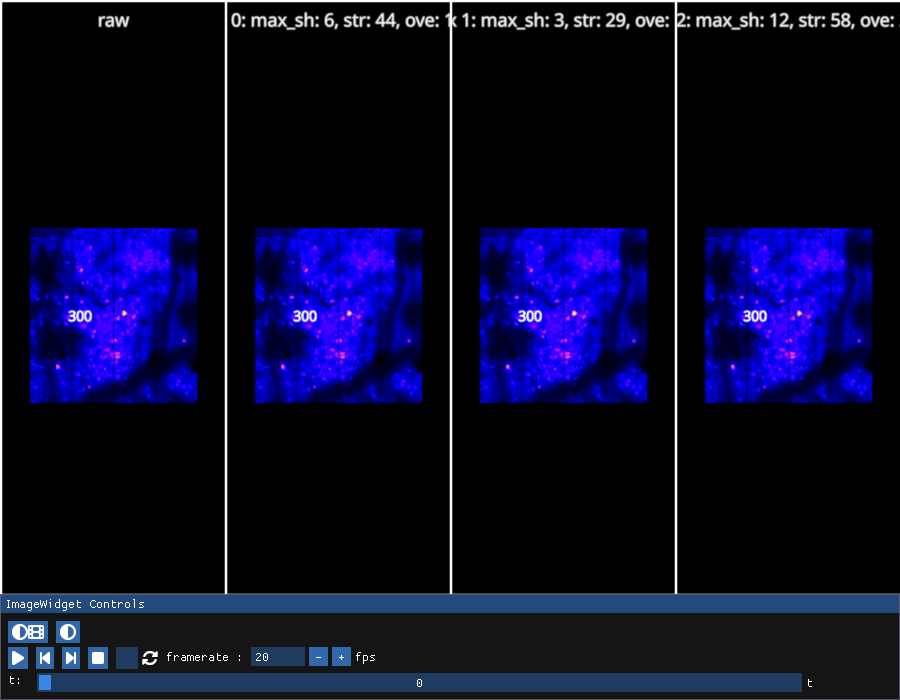

In [222]:
# Change the size/shape depending on how many parameter sweep inputs you used
figure_kwargs={"size": (900, 700), "shape": (1, len(movies))}

mcorr_iw_multiple = fpl.ImageWidget(
    data=movies,  # list of movies
    window_funcs={"t": (np.mean, 7)}, # window functions as a kwarg, this is what the slider was used for in the ready-made viz
    figure_kwargs=figure_kwargs,
    names=subplot_names,  # subplot names used for titles
    cmap="gnuplot2"
)

# free up some space
for subplot in mcorr_iw_multiple.figure:
    subplot.docks["right"].size = 0
    subplot.toolbar = False

mcorr_iw_multiple.show()

In [135]:
mcorr_iw_multiple.window_funcs["t"].window_size = 13

In [223]:
mcorr_iw_multiple.close()

## Apply the 'best parameters' to remaining files

When you decide which parameter set works the best, we keep it and delete the other batch items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

```{warning}
On windows, you will get an error `PermissionError: You do not have permissions to remove the output data for the batch item, aborting.` 

This can happen if you forgot to close one of the above widgets, or if you have a memory mapped file open.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

The solution is to restart your kernel. You will need to re-run the cells that define your batch/bath and reload your batch
with df = mc.load_batch(batch_path). Make sure `mc.set_raw_parent_data_path()` is in the re-run cells.
```

In [ ]:
rows_keep = [2]
for i, row in df.iterrows():
    if i not in rows_keep:
        df.caiman.remove_item(row.uuid, safe_removal=False)
df

## Apply registration using the same parameters to the remaining files

In [ ]:
for i in range(len(tiff_files)):

    # don't re-process the same file
    if tiff_files[i].name == df.iloc[0].input_movie_path:
        continue

    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=tiff_files[i],
        params= df.iloc[0].params,          # use the same parameters
        item_name=f'{tiff_files[i].name}',  # filename of the movie, but can be anything
    )

Processing: /home/flynn/caiman_data/out2/plane_21.tiff
Processing: /home/flynn/caiman_data/out2/plane_1.tiff
Processing: /home/flynn/caiman_data/out2/plane_16.tiff


In [83]:
df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
1,mcorr,plane_0,plane_21.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,2918ff63-f204-4334-8837-ea172af89e39
2,mcorr,plane_2,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,245bb955-feb9-4245-86bf-dd6ec1c79e95


In [84]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


finished computing correlation image
